In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score 

## Define business goal / question of interest / research question
We are trying to predict who survived on Titanic

### Read the Data

In [2]:
df = pd.read_csv('data/train.csv', index_col = 'PassengerId')
df_test = pd.read_csv('data/test.csv', index_col = 'PassengerId')
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


### Exlore Data

- survival 0 = No, 1 = Yes
- pclass Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd
- sibsp number of siblings / spouses aboard the Titanic
- parch number of parents / children aboard the Titanic
- ticket Ticket number
- cabin Cabin number
- embarked Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


We have missing values at Age, Cabin, Embarked

In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


We have missing values at Age, Cabin, Fare

Age is float number, try to make int and check results. Also we can try to split age to groups

Same with Fare, i dont think it makes big difference the float

In [5]:
df[['Fare', 'Age']] = df[['Fare', 'Age']].round(0)
df['Fare'] = df['Fare'].apply(lambda x: x if x != x else int(x))
df['Age'] = df['Age'].apply(lambda x: x if x != x else int(x))
df_test[['Fare', 'Age']] = df_test[['Fare', 'Age']].round(0)
df_test['Fare'] = df_test['Fare'].apply(lambda x: x if x != x else int(x))
df_test['Age'] = df_test['Age'].apply(lambda x: x if x != x else int(x))

In [6]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.693277,0.523008,0.381594,32.214366
std,0.486592,0.836071,14.524527,1.102743,0.806057,49.693352
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.000000,0.000000,0.000000,8.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.000000
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.000000


In [7]:
len(df['Ticket'].unique())

681

I guess Some families used same ticket, maybe we can use it

Plot dependences from numeric features

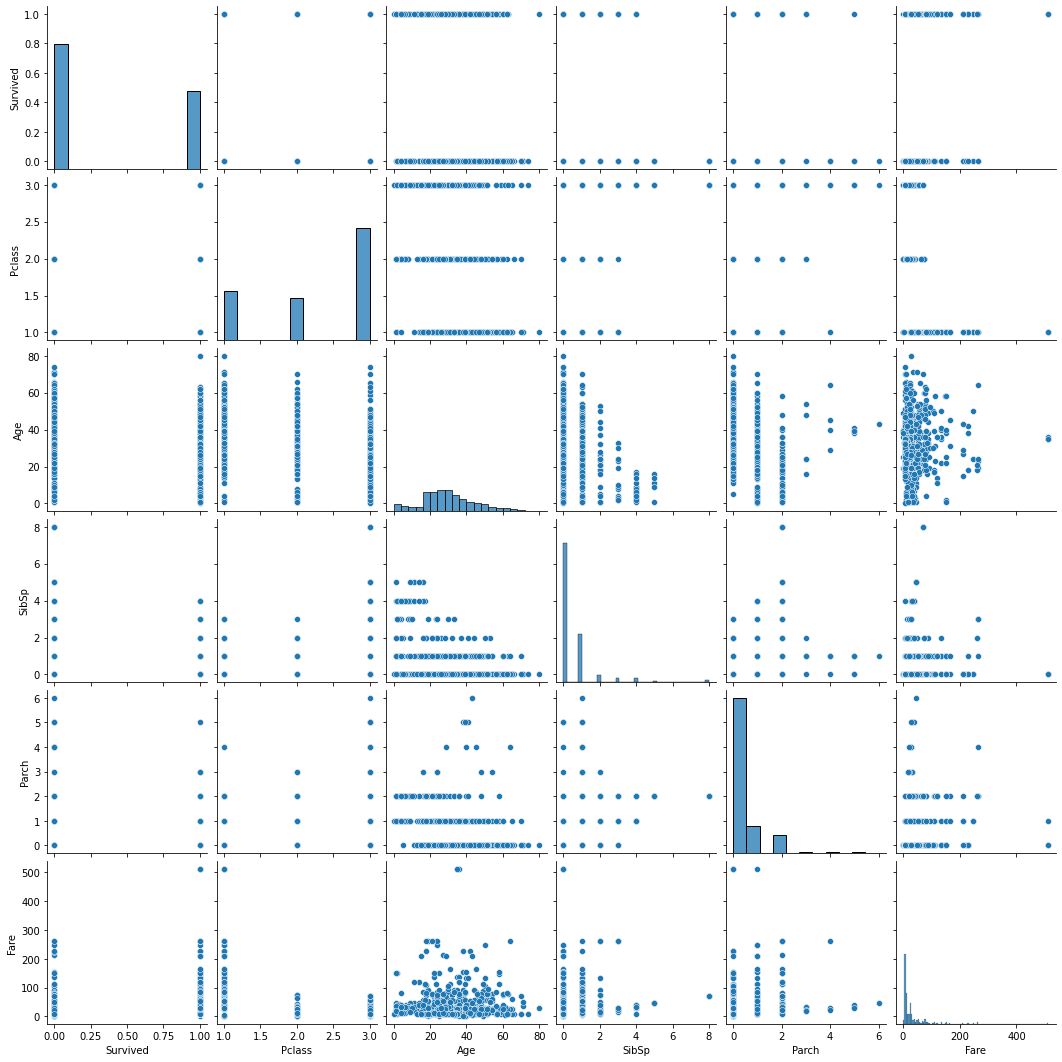

In [8]:
sns.pairplot(df)

Check correlation

<AxesSubplot:>

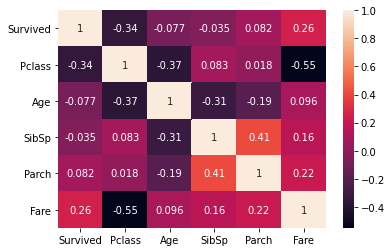

In [9]:
sns.heatmap(df.corr(),annot=True)

We dont see highly correlated features. Sib and Parch have low correlance with survived

Distribution of Age and Fare

In [10]:
df.loc[df['SibSp']>3]
# We can see that many fam with many children travel 3rd class
# Why children called Master?

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
17,0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29,NaN,Q
51,0,3,"Panula, Master. Juha Niilo",male,7.0,4,1,3101295,40,NaN,S
60,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,47,NaN,S
69,1,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,8,NaN,S
72,0,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,47,NaN,S
120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31,NaN,S
160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,70,NaN,S
165,0,3,"Panula, Master. Eino Viljami",male,1.0,4,1,3101295,40,NaN,S
172,0,3,"Rice, Master. Arthur",male,4.0,4,1,382652,29,NaN,Q


<AxesSubplot:xlabel='Embarked', ylabel='Count'>

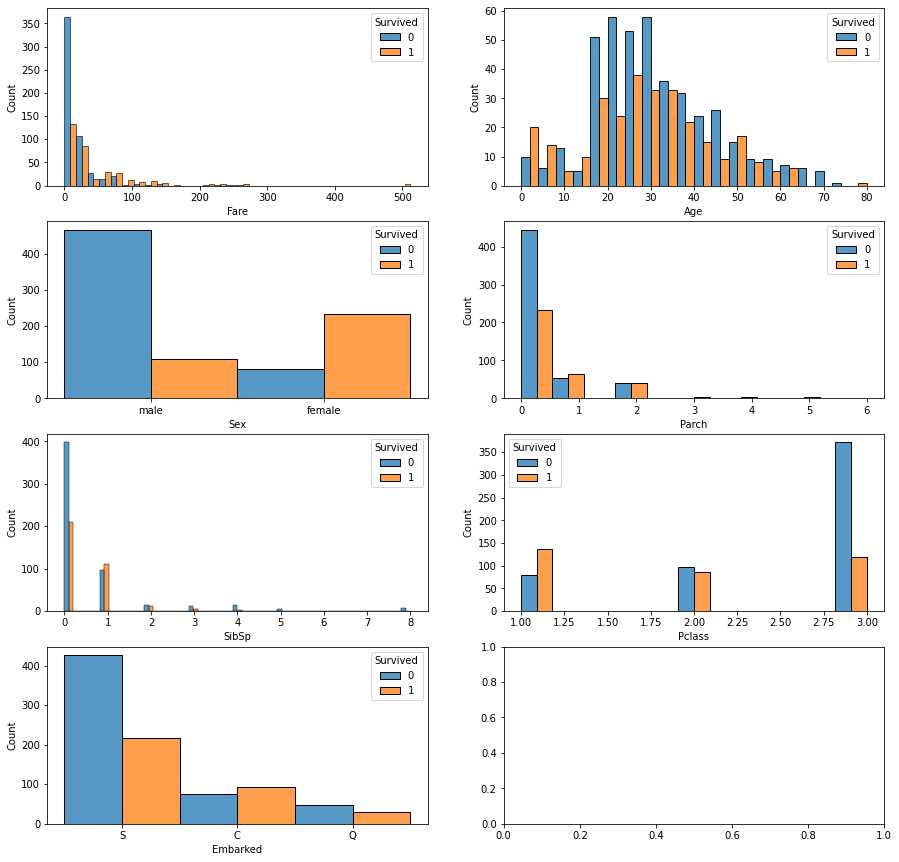

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=2)
fig.set_size_inches(15, 15)
sns.histplot(df, x = 'Fare', multiple="dodge", hue = 'Survived', ax = axes[0,0], bins=30)
sns.histplot(df, x = 'Age', multiple="dodge", hue = 'Survived', ax = axes[0,1])
sns.histplot(df, x = 'Sex', multiple="dodge", hue = 'Survived', ax = axes[1,0])
sns.histplot(df, x = 'Parch', multiple="dodge", hue = 'Survived', ax = axes[1,1])
sns.histplot(df, x = 'SibSp', multiple="dodge", hue = 'Survived', ax = axes[2,0])
sns.histplot(df, x = 'Pclass', multiple="dodge", hue = 'Survived', ax = axes[2,1])
sns.histplot(df.loc[df['Embarked'].notna()], x = 'Embarked', multiple="dodge", hue = 'Survived', ax = axes[3,0])


Conclusions:
- High rate has better survival, some outliers better to take out
- Small children and ppl older than 30 better
- Female better
- Up to 3 children
- Family of 2 and 3
- First class

Distribution of Age between Cabine class

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

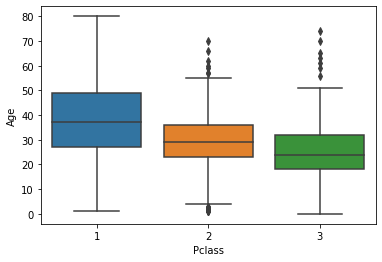

In [12]:
df_plot = pd.DataFrame(df[['Pclass', 'Age']])
df_plot = df_plot.reset_index()
plot_1 = sns.boxplot(x='Pclass', y='Age', data=df_plot)
plot_1

In [13]:
np.sort(df['Fare'].unique())

array([  0,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  42,
        47,  50,  51,  52,  53,  55,  56,  57,  58,  59,  61,  62,  63,
        65,  67,  69,  70,  71,  74,  75,  76,  77,  78,  79,  80,  82,
        83,  86,  89,  90,  91,  94, 106, 109, 111, 113, 120, 134, 136,
       147, 152, 153, 165, 211, 212, 222, 228, 248, 262, 263, 512])

In [14]:
df['Cabin'].unique() # I will use lettres

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [91]:
def extract_letter(x):
    res = 0
    if 'A' in x: res = 1
    elif 'B' in x: res = 2     
    elif 'C' in x: res = 3
    elif 'D' in x: res = 4 
    elif 'E' in x: res = 5
    elif 'F' in x: res = 6
    elif 'G' in x: res = 7
    return res    

In [92]:
def family_size(x):
        res = 0
        if x == 0:
            res = 0
        elif x==1:
            res = 1
        elif x<=2:
            res = 2
        else:
            res = 3
        return res

In [93]:
def clean_data(df):
    
    # Fill missing values
    emb = df['Embarked'].mode()
    f = df['Fare'].mean()
    df = df.fillna({'Embarked': emb,'Fare': f})
#      Get rid of high fare
    df.loc[df['Fare'] > 200, 'Fare'] = 200
    # Get mean age for different cabine classes
    a = df.loc[df['Pclass']==1, 'Age'].mean().round(0)
    b = df.loc[df['Pclass']==2, 'Age'].mean().round(0)
    c = df.loc[df['Pclass']==3, 'Age'].mean().round(0)
    
    df.loc[df['Pclass'] == 1, 'Age'] = df.loc[df['Pclass'] == 1, 'Age'].fillna(a)
    df.loc[df['Pclass'] == 2, 'Age'] = df.loc[df['Pclass'] == 2, 'Age'].fillna(b)
    df.loc[df['Pclass'] == 3, 'Age'] = df.loc[df['Pclass'] == 3, 'Age'].fillna(c)
    
    df['Cabin'] = df['Cabin'].apply(lambda x: 0 if x != x else extract_letter(x))
    
    df['Fam'] = df['SibSp']+df['Parch']
    df['Fam'] = df['Fam'].apply(family_size)

#     Dummies overfit RF model
#     df[['C','Q','S']] = pd.get_dummies(df['Embarked'])
#     df[['C_A','C_B', 'C_C', 'C_D', 'C_E', 'C_F', 'C_G', 'C_T']] = pd.get_dummies(df['Cabin'], drop_first=True)
    
    label =  LabelEncoder()
    df['Sex'] = label.fit_transform(df['Sex'])
    df['Embarked'] = label.fit_transform(df['Embarked'])

    X_copy = df.drop(['Name', 'Ticket', 'SibSp', 'Parch'], axis = 1)
#     scaler = StandardScaler()
    X = X_copy.copy()
#     Scaling doent make a difference with our models, also should be similar to test deta    
#     X['Age'] = scaler.fit_transform(X_copy[['Age']])
#     X['Fare'] = scaler.fit_transform(X_copy[['Fare']])
#     X['Pclass'] = scaler.fit_transform(X_copy[['Pclass']])
#     X['Fam'] = scaler.fit_transform(X_copy[['Fam']])
#     X['Fam'] = scaler.fit_transform(X_copy[['Fam']])
    return X

In [94]:
df_ = clean_data(df)

In [95]:
df_.head(20)

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Fam
PassengerId,,,,,,,,
1,0,3,1,22.0,7,0,2,1
2,1,1,0,38.0,71,3,0,1
3,1,3,0,26.0,8,0,2,0
4,1,1,0,35.0,53,3,2,1
5,0,3,1,35.0,8,0,2,0
6,0,3,1,25.0,8,0,1,0
7,0,1,1,54.0,52,5,2,0
8,0,3,1,2.0,21,0,2,3
9,1,3,0,27.0,11,0,2,2


In [96]:
X = df_.drop(['Survived'], axis = 1)
y = df_['Survived']
X

,Pclass,Sex,Age,Fare,Cabin,Embarked,Fam
PassengerId,,,,,,,
1,3,1,22.0,7,0,2,1
2,1,0,38.0,71,3,0,1
3,3,0,26.0,8,0,2,0
4,1,0,35.0,53,3,2,1
5,3,1,35.0,8,0,2,0
...,...,...,...,...,...,...,...
887,2,1,27.0,13,0,2,0
888,1,0,19.0,30,2,2,0
889,3,0,25.0,23,0,2,3


In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state =3 )

In [98]:
rf = RandomForestClassifier(random_state = 100, max_depth = 3, 
                            n_estimators = 400, max_features = 'auto',
                            bootstrap = True)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=400, random_state=100)

In [99]:
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)
rf.score(X_train,y_train), rf.score(X_test,y_test)

(0.8413173652694611, 0.7937219730941704)

(0.8697604790419161, 0.7937219730941704)

In [67]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [68]:
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'n_estimators': [100, 200, 300, 400, 500],
#     'random_state': [0, 100, 250],            
}

In [69]:
cv = GridSearchCV(rf, param_grid, 
                  return_train_score=True, 
                  scoring='f1', 
                  cv=10, n_jobs=4)

In [70]:
cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': [3, 4, 5, 6],
                         'n_estimators': [100, 200, 300, 400, 500]},
             return_train_score=True, scoring='f1')

In [71]:
res = pd.DataFrame(cv.cv_results_)
res['overfit']=res['mean_train_score']-res['mean_test_score']
c = res.columns 

In [72]:
c = ['overfit','mean_test_score', 'mean_train_score', 'param_max_depth',
     'param_n_estimators', 
      'mean_fit_time']

In [73]:
res = res[c]
res = res.sort_values(by=['mean_test_score'])
rf_best = cv.best_estimator_ 
rf_best_my = [8, 100, 'auto', True, 4, 100, 'sqrt', True]
res

,overfit,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,mean_fit_time
1,0.045066,0.708566,0.753633,3,200,1.720274
4,0.045307,0.713649,0.758955,3,500,2.059192
0,0.042476,0.716260,0.758735,3,100,0.748934
2,0.041826,0.717006,0.758832,3,300,1.650635
3,0.036775,0.721303,0.758077,3,400,1.632344
5,0.063940,0.731685,0.795624,4,100,0.416579
7,0.059191,0.739038,0.798229,4,300,1.200026
6,0.055545,0.740562,0.796107,4,200,0.810664
12,0.078698,0.742337,0.821035,5,300,1.289577
11,0.078116,0.743843,0.821959,5,200,1.026815


**Decision Tree**

In [100]:
dt = DecisionTreeClassifier(random_state=100, max_depth = 5, min_samples_leaf = 5, criterion = 'entropy',
                           min_samples_split = 5)
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5,
                       min_samples_split=5, random_state=100)

In [101]:
dt.score(X_train, y_train), dt.score(X_test, y_test)

(0.8607784431137725, 0.7757847533632287)

In [76]:
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 100,
 'splitter': 'best'}

In [77]:
param_grid2 = {
    'max_depth': [3, 4, 5, 6],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 3, 4, 5],
    'max_features': ['auto', 'sqrt'],            
}

In [78]:
cv2 = GridSearchCV(dt, 
                  param_grid2, 
                  return_train_score=True, 
                  scoring='f1', 
                  cv=10, n_jobs=4)
cv2.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(criterion='entropy', max_depth=6,
                                              random_state=100),
             n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5]},
             return_train_score=True, scoring='f1')

In [79]:
res2 = pd.DataFrame(cv2.cv_results_)
res2['overfit']=res2['mean_train_score']-res2['mean_test_score']
c2 = ['overfit','mean_test_score', 'mean_train_score', 'param_max_depth', 
     'param_criterion', 'param_min_samples_leaf', 'param_min_samples_split',
     'param_max_features', 'mean_fit_time']
res2 = res2[c2]
res2 = res2.sort_values(by=['mean_test_score'])
dt_best = cv2.best_estimator_ 
dt_best_my = [8, 'gini', 1, 5, 'sqrt']
res2[:-10]

,overfit,mean_test_score,mean_train_score,param_max_depth,param_criterion,param_min_samples_leaf,param_min_samples_split,param_max_features,mean_fit_time
26,0.050717,0.624964,0.675681,3,gini,2,4,sqrt,0.009017
24,0.050717,0.624964,0.675681,3,gini,2,2,sqrt,0.009739
27,0.050717,0.624964,0.675681,3,gini,2,5,sqrt,0.010296
4,0.050717,0.624964,0.675681,3,gini,2,2,auto,0.021643
5,0.050717,0.624964,0.675681,3,gini,2,3,auto,0.017169
...,...,...,...,...,...,...,...,...,...
81,0.051550,0.739119,0.790669,5,gini,1,3,auto,0.011932
262,0.047260,0.742099,0.789359,5,entropy,1,4,sqrt,0.008423
242,0.047260,0.742099,0.789359,5,entropy,1,4,auto,0.009076
107,0.043469,0.743400,0.786869,5,gini,2,5,sqrt,0.009371


**LOGISTIC REGRESSION**

In [102]:
lg = LogisticRegression(random_state=100, max_iter=800, C = 1)
lg.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=800, random_state=100)

In [103]:
lg.score(X_train, y_train), lg.score(X_test, y_test)

(0.8188622754491018, 0.7847533632286996)

In [82]:
param_grid3 = {
    'tol': [0.000001, 0.1, 3],
    'C': [100, 10, 1, 0.1, 0.01],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
}

In [83]:
cv3 = GridSearchCV(lg, 
                  param_grid3, 
                  return_train_score=True, 
                  scoring='f1', 
                  cv=10, n_jobs=4)
cv3.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(C=1, max_iter=800, random_state=100),
             n_jobs=4,
             param_grid={'C': [100, 10, 1, 0.1, 0.01],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga'],
                         'tol': [1e-06, 0.1, 3]},
             return_train_score=True, scoring='f1')

In [84]:
res3 = pd.DataFrame(cv3.cv_results_)
res3['overfit']=res3['mean_train_score']-res3['mean_test_score']
c3 = ['overfit','mean_test_score', 'mean_train_score', 'param_tol', 
     'param_C', 'param_solver', 'mean_fit_time']
res3 = res3[c3]
res3 = res3.sort_values(by=['mean_test_score'])
lg_best = cv3.best_estimator_ 
lg_best_my = [3, 1, 1, 'newton-cg']
res3[:-10]

,overfit,mean_test_score,mean_train_score,param_tol,param_C,param_solver,mean_fit_time
8,0.000000,0.000000,0.000000,3,100,liblinear,0.009247
38,0.000000,0.000000,0.000000,3,1,liblinear,0.011537
68,0.000000,0.000000,0.000000,3,0.01,liblinear,0.008445
23,0.000000,0.000000,0.000000,3,10,liblinear,0.009825
53,0.000000,0.000000,0.000000,3,0.10,liblinear,0.012338
...,...,...,...,...,...,...,...
40,0.008672,0.733642,0.742314,0.100000,1,sag,0.015375
30,0.013849,0.733747,0.747596,0.000001,1,newton-cg,0.034333
31,0.014020,0.733747,0.747767,0.100000,1,newton-cg,0.024030
33,0.013849,0.733747,0.747596,0.000001,1,lbfgs,0.023568


**Voting Classifier**

In [104]:
lg_best.fit(X_train, y_train)
dt_best.fit(X_train, y_train)
rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, n_estimators=500)

In [105]:
rf_best.score(X_train,y_train), rf_best.score(X_test,y_test)

(0.8922155688622755, 0.7802690582959642)

In [106]:
lg_best.score(X_train,y_train), lg_best.score(X_test,y_test)

(0.8098802395209581, 0.7757847533632287)

In [107]:
dt_best.score(X_train,y_train), dt_best.score(X_test,y_test)

(0.8473053892215568, 0.7802690582959642)

In [108]:
eclf = VotingClassifier(estimators=[('lg', lg_best), ('rf', rf_best), ('dt', dt_best)], 
                        voting='hard')
eclf = eclf.fit(X_train, y_train)
eclf.score(X_train, y_train), eclf.score(X_test, y_test)

(0.8592814371257484, 0.7892376681614349)

In [109]:
X_test2 = clean_data(df_test)
X_test2

,Pclass,Sex,Age,Fare,Cabin,Embarked,Fam
PassengerId,,,,,,,
892,3,1,34.0,8.0,0,1,0
893,3,0,47.0,7.0,0,2,1
894,2,1,62.0,10.0,0,1,0
895,3,1,27.0,9.0,0,2,0
896,3,0,22.0,12.0,0,2,2
...,...,...,...,...,...,...,...
1305,3,1,24.0,8.0,0,2,0
1306,1,0,39.0,109.0,3,0,0
1307,3,1,38.0,7.0,0,2,0


I choose Random Forest fro final prediction

In [118]:
y_res = eclf.predict(X_test2)
y_res

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [119]:
df_test['Survived'] = y_res
result = df_test['Survived']
result

PassengerId
892     0
893     0
894     0
895     0
896     0
       ..
1305    0
1306    1
1307    0
1308    0
1309    0
Name: Survived, Length: 418, dtype: int64

In [120]:
result = result.reset_index()
result

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [121]:
result.to_csv('submission8.csv', index=False)